In [315]:
import cv2
import numpy as np
import os
import sys
import time
import matplotlib.pyplot as plt

Загрузка изображения

In [316]:
img_path = '/home/evgen/Coursework/dct_compress/800_600.jpg' # fisherman-4465032_960_720.jpg

img = cv2.imread(img_path, cv2.IMREAD_COLOR) #COLOR_YCrCb2BGR cv2.COLOR_BGR2YCR_CB)

if img is None:
    print("Ошибка: изображение не загружено. Проверьте путь к файлу.")
else:
    # Преобразование в цветовое пространство YCrCb
    img_ycrcb = cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)

    # cv2.imshow('Image in YCrCb', img_ycrcb)
    # cv2.waitKey(0)
    # cv2.destroyAllWindows()


In [317]:
memory_size = img.nbytes
print(f"Размер изображения в памяти: {memory_size/1024} kb")

Размер изображения в памяти: 1406.25 kb


Предобработка

In [318]:
# Приведение изображения к кратным размерам
def pad_image_to_multiple(img, block_size = 8):
    h, w, channels = img.shape

    # pad block size
    pad_h = (block_size - h % block_size) % block_size
    pad_w = (block_size - w % block_size) % block_size
    # print(pad_h, pad_w)

    new_h = h + pad_h
    new_w = w + pad_w

    new_img = np.zeros((new_h, new_w, channels), dtype=np.uint8)
    new_img[:h, :w] = img

    return new_img



In [319]:
def split_into_blocs(img, block_size = 8):
    h, w, channels = img.shape

    blocks = img.reshape(h // block_size, block_size,
                         w // block_size, block_size, 
                         channels)
    

    #Меняем оси для правильной структуры блоков
    blocks = blocks.swapaxes(1, 2)
    return blocks

Применение "дискретно-косинусного преобразования"

In [320]:
# DCT
def dct2D(block):

    """
    Реализация 2D DCT для блока N x N.
    :param block: входной блок размером N x N
    :return: коэффициенты DCT размером N x N
    """

    N = block.shape[0]
    dct_res = np.zeros((N, N), dtype=np.float32)
    alpha = lambda k : np.sqrt(1/N) if k == 0 else np.sqrt(2/N)

    for u in range(N):
        for v in range(N):
            sum_value = 0.0
            for x in range(N):
                for y in range(N):
                    sum_value += block[x, y] * \
                                 np.cos((2 * x + 1) * u * np.pi / (2 * N)) * \
                                 np.cos((2 * y + 1) * v * np.pi / (2 * N))
            dct_res[u, v] = alpha(u) * alpha(v) * sum_value

    return dct_res

In [321]:
def apply_dct_to_blocks(blocks):
    """
    Применить 2D DCT к каждому блоку изображения.
    :param blocks: блоки изображения размером (H, W, block_size, block_size, channels)
    :return: коэффициенты DCT для каждого блока
    """
    H, W, block_size, _, channels = blocks.shape
    dct_blocks = np.zeros_like(blocks, dtype=np.float32)

    # Применяем DCT к каждому блоку для каждого канала
    for i in range(H):
        for j in range(W):
            for c in range(channels):
                block = blocks[i, j, :, :, c]  # Извлекаем блок для текущего канала
                # dct_blocks[i, j, :, :, c] = dct2D(block)
                block = np.float32(block)
                dct_blocks[i, j, :, :, c] = cv2.dct(block)

    return dct_blocks

In [322]:
new_im = pad_image_to_multiple(img_ycrcb, 8)
blocks = split_into_blocs(new_im, 8)

start_time = time.time()
res = apply_dct_to_blocks(blocks)
pad_time = time.time() - start_time
print("time:", pad_time)

time: 0.14635992050170898


Квантование коэффициентов

In [323]:
#Пример матриц квантования для каждого канала
# quant_matrices = [
#     np.array([  # Матрица для Y (яркость)
#         [16, 11, 10, 16, 24, 40, 51, 61],
#         [12, 12, 14, 19, 26, 58, 60, 55],
#         [14, 13, 16, 24, 40, 57, 69, 56],
#         [14, 17, 22, 29, 51, 87, 80, 62],
#         [18, 22, 37, 56, 68, 109, 103, 77],
#         [24, 35, 55, 64, 81, 104, 113, 92],
#         [49, 64, 78, 87, 103, 121, 120, 101],
#         [72, 92, 95, 98, 112, 100, 103, 99]
#     ]),
#     np.array([  # Матрица для Cb (синий компонент цветности)
#         [17, 18, 24, 47, 99, 99, 99, 99],
#         [18, 21, 26, 66, 99, 99, 99, 99],
#         [24, 26, 56, 99, 99, 99, 99, 99],
#         [47, 66, 99, 99, 99, 99, 99, 99],
#         [99, 99, 99, 99, 99, 99, 99, 99],
#         [99, 99, 99, 99, 99, 99, 99, 99],
#         [99, 99, 99, 99, 99, 99, 99, 99],
#         [99, 99, 99, 99, 99, 99, 99, 99]
#     ]),
#     np.array([  # Матрица для Cr (красный компонент цветности)
#         [17, 18, 24, 47, 99, 99, 99, 99],
#         [18, 21, 26, 66, 99, 99, 99, 99],
#         [24, 26, 56, 99, 99, 99, 99, 99],
#         [47, 66, 99, 99, 99, 99, 99, 99],
#         [99, 99, 99, 99, 99, 99, 99, 99],
#         [99, 99, 99, 99, 99, 99, 99, 99],
#         [99, 99, 99, 99, 99, 99, 99, 99],
#         [99, 99, 99, 99, 99, 99, 99, 99]
#     ])
# ]

quant_matrices = [
    np.array([  # Матрица для Y (яркость)
        [24, 17, 15, 24, 36, 60, 77, 92],
        [18, 18, 21, 28, 39, 87, 90, 83],
        [21, 19, 24, 36, 60, 85, 104, 84],
        [21, 25, 33, 44, 77, 131, 120, 93],
        [27, 33, 56, 84, 102, 164, 154, 116],
        [36, 52, 83, 96, 122, 157, 170, 138],
        [73, 96, 117, 131, 154, 182, 180, 151],
        [108, 138, 143, 147, 168, 150, 154, 148]
    ]),
    np.array([  # Матрица для Cb (синий компонент цветности)
        [43, 45, 60, 117, 248, 248, 248, 248],
        [45, 53, 66, 165, 248, 248, 248, 248],
        [60, 66, 143, 248, 248, 248, 248, 248],
        [117, 165, 248, 248, 248, 248, 248, 248],
        [248, 248, 248, 248, 248, 248, 248, 248],
        [248, 248, 248, 248, 248, 248, 248, 248],
        [248, 248, 248, 248, 248, 248, 248, 248],
        [248, 248, 248, 248, 248, 248, 248, 248]
    ]),
    np.array([  # Матрица для Cr (красный компонент цветности)
        [43, 45, 60, 117, 248, 248, 248, 248],
        [45, 53, 66, 165, 248, 248, 248, 248],
        [60, 66, 143, 248, 248, 248, 248, 248],
        [117, 165, 248, 248, 248, 248, 248, 248],
        [248, 248, 248, 248, 248, 248, 248, 248],
        [248, 248, 248, 248, 248, 248, 248, 248],
        [248, 248, 248, 248, 248, 248, 248, 248],
        [248, 248, 248, 248, 248, 248, 248, 248]
    ])
]

In [324]:
# def quantize_dct_blocks(dct_blocks, quant_matrix):
#     """
#     Применить квантование к каждому блоку коэффициентов DCT.
#     :param dct_blocks: массив коэффициентов DCT (H, W, block_size, block_size, channels)
#     :param quant_matrix: матрица квантования коэффициентов (block_size x block_size)
#     :return: квантизированные коэффициенты
#     """
#     H, W, block_size, _, channels = dct_blocks.shape
#     quantized_blocks = np.zeros_like(dct_blocks, dtype=np.int32)

#     for i in range(H):
#         for j in range(W):
#             for c in range(channels):
#                 quantized_blocks[i, j, :, :, c] = np.round(dct_blocks[i, j, :, :, c] / quant_matrix)

#     return quantized_blocks

def quantize_dct_blocks_multi_channel(dct_blocks, quant_matrices):
    """
    Применить квантование к каждому блоку коэффициентов DCT с разными матрицами для каждого канала.
    :param dct_blocks: массив коэффициентов DCT (H, W, block_size, block_size, channels)
    :param quant_matrices: список матриц квантования для каждого канала [(block_size x block_size), ...]
    :return: квантованые коэффициенты
    """
    H, W, block_size, _, channels = dct_blocks.shape
    quantized_blocks = np.zeros_like(dct_blocks, dtype=np.int32)

    for c in range(channels):
        for i in range(H):
            for j in range(W):
                quantized_blocks[i, j, :, :, c] = np.round(dct_blocks[i, j, :, :, c] / quant_matrices[c])

    return quantized_blocks

# Квантуем коэффициенты
quantized_dct_blocks = quantize_dct_blocks_multi_channel(res, quant_matrices)

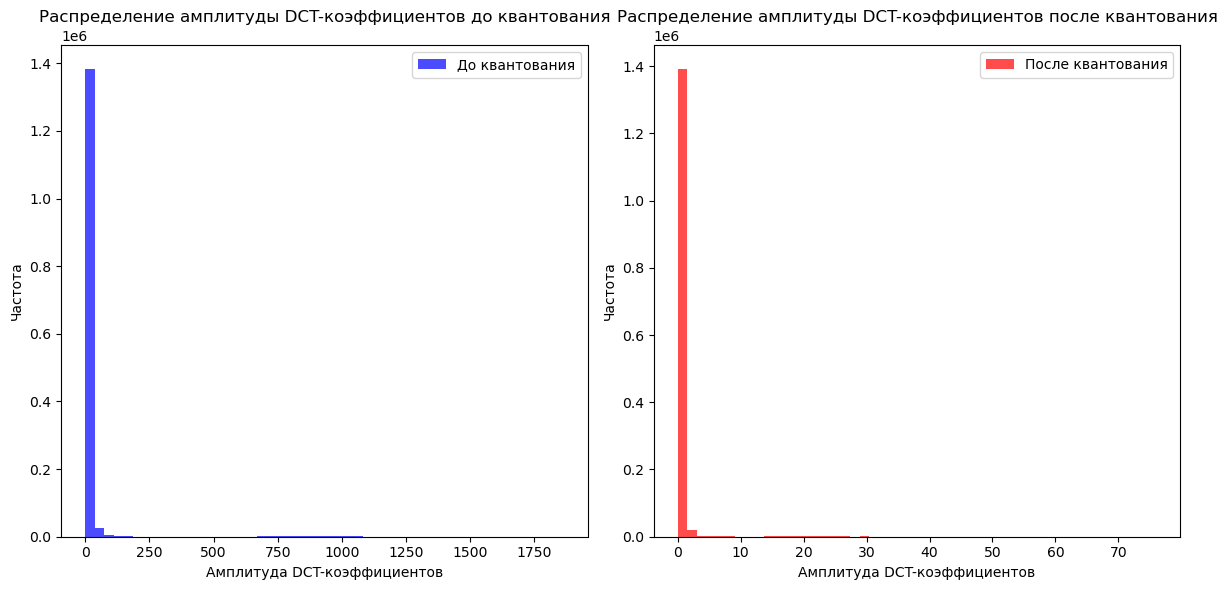

In [345]:
# Визуализация амплитуды коэффициентов DCT до и после квантования
dct_amplitudes = np.abs(res).flatten()
quantized_amplitudes = np.abs(quantized_dct_blocks).flatten()

plt.figure(figsize=(12, 6))

# Амплитуда до квантования
plt.subplot(1, 2, 1)
plt.hist(dct_amplitudes, bins=50, color='blue', alpha=0.7, label="До квантования")
plt.title("Распределение амплитуды DCT-коэффициентов до квантования")
plt.xlabel("Амплитуда DCT-коэффициентов")
plt.ylabel("Частота")
plt.legend()

# Амплитуда после квантования
plt.subplot(1, 2, 2)
plt.hist(quantized_amplitudes, bins=50, color='red', alpha=0.7, label="После квантования")
plt.title("Распределение амплитуды DCT-коэффициентов после квантования")
plt.xlabel("Амплитуда DCT-коэффициентов")
plt.ylabel("Частота")
plt.legend()

plt.tight_layout()
plt.show()


Дальнейшая обработка коэффициентов

In [326]:
def zigzag_scan(block):
    """
    Преобразовать 2D-блок в зигзагообразный порядок.
    :param block: 2D массив (block_size x block_size)
    :return: 1D массив значений в зигзагообразном порядке
    """
    block_size = block.shape[0]
    result = []
    for i in range(2 * block_size - 1):
        if i % 2 == 0:
            for x in range(max(0, i - block_size + 1), min(i + 1, block_size)):
                result.append(block[x, i - x])
        else:
            for x in range(max(0, i - block_size + 1), min(i + 1, block_size)):
                result.append(block[i - x, x])
    return result


def zigzag_transform_blocks(quantized_blocks):
    """
    Преобразовать все блоки в зигзагообразный порядок.
    :param quantized_blocks: массив квантованных коэффициентов (H, W, block_size, block_size, channels)
    :return: массив зигзагообразных преобразований для каждого блока
    """
    H, W, block_size, _, channels = quantized_blocks.shape
    zigzag_blocks = np.zeros((H, W, block_size * block_size, channels), dtype=np.int32)

    for c in range(channels):
        for i in range(H):
            for j in range(W):
                zigzag_blocks[i, j, :, c] = zigzag_scan(quantized_blocks[i, j, :, :, c])

    return zigzag_blocks

In [327]:
# Преобразуем квантованные блоки
zigzag_blocks = zigzag_transform_blocks(quantized_dct_blocks)
print("Зигзаг для первого блока канала Y:", zigzag_blocks[0, 0, :, 1])

Зигзаг для первого блока канала Y: [12  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]


компрес RLE

In [328]:
def rle_encode(array):
    """
    Применить RLE-кодирование к массиву.
    :param array: входной одномерный массив
    :return: массив пар (значение, количество)
    """
    encoded = []
    prev_value = array[0]
    count = 1
    for value in array[1:]:
        if value == prev_value:
            count += 1
        else:
            encoded.append((prev_value, count))
            prev_value = value
            count = 1
    encoded.append((prev_value, count))  # Добавить последний элемент
    return encoded

# Пример кодирования одного блока
# zigzag_flatten = zigzag_blocks[0, 0, :, 0]  # Первый блок первого канала
# rle_result = rle_encode(zigzag_flatten)
# print(rle_result)



def apply_rle_to_all_blocks(zigzag_blocks):
    """
    Применить RLE-кодирование ко всем зигзагообразным блокам.
    :param zigzag_blocks: массив зигзагообразных преобразований (H, W, block_size^2, channels)
    :return: массив RLE-кодированных блоков
    """
    H, W, block_size_sq, channels = zigzag_blocks.shape
    rle_encoded_blocks = np.empty((H, W, channels), dtype=object)

    for c in range(channels):
        for i in range(H):
            for j in range(W):
                rle_encoded_blocks[i, j, c] = rle_encode(zigzag_blocks[i, j, :, c])

    return rle_encoded_blocks

# Применение RLE ко всем блокам
rle_encoded_blocks = apply_rle_to_all_blocks(zigzag_blocks)

# Пример: вывод результата для первого блока первого канала
print(rle_encoded_blocks)

[[[list([(29, 1), (0, 4), (1, 1), (0, 58)]) list([(12, 1), (0, 63)])
   list([(29, 1), (0, 63)])]
  [list([(30, 1), (0, 1), (-1, 1), (0, 61)]) list([(12, 1), (0, 63)])
   list([(29, 1), (0, 63)])]
  [list([(31, 1), (0, 63)]) list([(12, 1), (0, 63)])
   list([(29, 1), (0, 63)])]
  ...
  [list([(59, 1), (0, 63)]) list([(23, 1), (0, 63)])
   list([(21, 1), (0, 63)])]
  [list([(59, 1), (0, 63)]) list([(23, 1), (0, 63)])
   list([(21, 1), (0, 63)])]
  [list([(59, 1), (0, 63)]) list([(23, 1), (0, 63)])
   list([(21, 1), (0, 63)])]]

 [[list([(31, 1), (1, 1), (0, 62)]) list([(12, 1), (0, 63)])
   list([(29, 1), (0, 63)])]
  [list([(31, 1), (0, 63)]) list([(12, 1), (0, 63)])
   list([(29, 1), (0, 63)])]
  [list([(36, 1), (-3, 1), (-4, 1), (-1, 1), (2, 1), (-1, 1), (0, 2), (1, 1), (0, 55)])
   list([(12, 1), (-1, 2), (0, 61)]) list([(28, 1), (0, 63)])]
  ...
  [list([(60, 1), (0, 63)]) list([(23, 1), (0, 63)])
   list([(21, 1), (0, 63)])]
  [list([(60, 1), (0, 63)]) list([(23, 1), (0, 63)])
   

In [329]:
def optimize_rle_blocks(rle_encoded_blocks):
    """
    Уменьшить количество дублирующихся данных в RLE-кодированных блоках.
    :param rle_encoded_blocks: массив RLE-кодированных блоков
    :return: (уникальные элементы, индексы)
    """
    # Преобразуем массив в плоский список
    flat_list = rle_encoded_blocks.flatten()
    
    # Найдем уникальные элементы
    unique_blocks, inverse_indices = np.unique(flat_list, return_inverse=True)
    
    # Восстановим оригинальную форму с индексами уникальных элементов
    indices = inverse_indices.reshape(rle_encoded_blocks.shape)
    
    return unique_blocks, indices

def restore_rle_blocks(unique_blocks, indices):
    """
    Восстановить исходные RLE-кодированные блоки из уникальных элементов и индексов.
    :param unique_blocks: уникальные элементы
    :param indices: индексы
    :return: восстановленные RLE-блоки
    """
    # Восстановим плоский список с индексами
    restored_flat_list = unique_blocks[indices.flatten()]
    
    # Восстановим исходную форму
    restored_rle_blocks = restored_flat_list.reshape(indices.shape)
    
    return restored_rle_blocks

# Применение оптимизации
unique_blocks, indices = optimize_rle_blocks(rle_encoded_blocks)



# Восстановление исходных блоков
restored_rle_blocks = restore_rle_blocks(unique_blocks, indices)

# Пример вывода
print("Восстановленные RLE-блоки:")
print(restored_rle_blocks)

Восстановленные RLE-блоки:
[[[list([(29, 1), (0, 4), (1, 1), (0, 58)]) list([(12, 1), (0, 63)])
   list([(29, 1), (0, 63)])]
  [list([(30, 1), (0, 1), (-1, 1), (0, 61)]) list([(12, 1), (0, 63)])
   list([(29, 1), (0, 63)])]
  [list([(31, 1), (0, 63)]) list([(12, 1), (0, 63)])
   list([(29, 1), (0, 63)])]
  ...
  [list([(59, 1), (0, 63)]) list([(23, 1), (0, 63)])
   list([(21, 1), (0, 63)])]
  [list([(59, 1), (0, 63)]) list([(23, 1), (0, 63)])
   list([(21, 1), (0, 63)])]
  [list([(59, 1), (0, 63)]) list([(23, 1), (0, 63)])
   list([(21, 1), (0, 63)])]]

 [[list([(31, 1), (1, 1), (0, 62)]) list([(12, 1), (0, 63)])
   list([(29, 1), (0, 63)])]
  [list([(31, 1), (0, 63)]) list([(12, 1), (0, 63)])
   list([(29, 1), (0, 63)])]
  [list([(36, 1), (-3, 1), (-4, 1), (-1, 1), (2, 1), (-1, 1), (0, 2), (1, 1), (0, 55)])
   list([(12, 1), (-1, 2), (0, 61)]) list([(28, 1), (0, 63)])]
  ...
  [list([(60, 1), (0, 63)]) list([(23, 1), (0, 63)])
   list([(21, 1), (0, 63)])]
  [list([(60, 1), (0, 63)]) l

In [330]:
# Размер массива unique_blocks в байтах
size_in_bytes_unique = unique_blocks.nbytes

# Размер массива indices в байтах
size_in_bytes_indices = indices.nbytes

# Общий размер в байтах
total_size_in_bytes = size_in_bytes_unique + size_in_bytes_indices

# Перевести общий размер в килобайты
total_size_in_kb = total_size_in_bytes / 1024

print(f"Общий размер массивов unique_blocks и indices: {total_size_in_kb:.2f} KB")

Общий размер массивов unique_blocks и indices: 257.82 KB


In [331]:
# Подсчет памяти для массива RLE-кодированных блоков
def calculate_memory_size(rle_encoded_blocks):
    total_size = 0
    for i in range(rle_encoded_blocks.shape[0]):
        for j in range(rle_encoded_blocks.shape[1]):
            for c in range(rle_encoded_blocks.shape[2]):
                total_size += sys.getsizeof(rle_encoded_blocks[i, j, c])
    return total_size

memory_size_bytes = calculate_memory_size(rle_encoded_blocks)
memory_size_kb = memory_size_bytes / 1024
print(f"Размер RLE-кодированного массива: {memory_size_bytes} байт ({memory_size_kb:.2f} KB)")

Размер RLE-кодированного массива: 2763104 байт (2698.34 KB)


Декомпрессия RLE

In [332]:
def rle_decode(rle_data):
    """
    Декодировать массив, закодированный с помощью RLE.
    :param rle_data: массив пар (значение, количество)
    :return: декодированный 1D массив
    """
    decoded = []
    for value, count in rle_data:
        decoded.extend([value] * count)
    return decoded

In [333]:
def decode_rle_from_all_blocks(rle_encoded_blocks):
    """
    Применить декодирование RLE ко всем блокам.
    :param rle_encoded_blocks: массив RLE-кодированных блоков (H, W, channels)
    :return: массив зигзагообразных блоков (H, W, block_size^2, channels)
    """
    H, W, channels = rle_encoded_blocks.shape
    # Предполагаем, что блокы квадратные и имеют одинаковый размер
    # Восстанавливаем размерность на основе количества элементов в одном блоке
    block_size_sq = len(rle_decode(rle_encoded_blocks[0, 0, 0]))
    zigzag_blocks = np.zeros((H, W, block_size_sq, channels), dtype=np.int32)

    for c in range(channels):
        for i in range(H):
            for j in range(W):
                zigzag_blocks[i, j, :, c] = rle_decode(rle_encoded_blocks[i, j, c])

    return zigzag_blocks


In [334]:
# Декодируем все блоки
decoded_zigzag_blocks = decode_rle_from_all_blocks(rle_encoded_blocks)

# Проверим восстановление первого блока первого канала
print("Декодированный первый блок (первый канал):")
print(decoded_zigzag_blocks[0, 0, :, 0])

Декодированный первый блок (первый канал):
[29  0  0  0  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]


In [335]:
def inverse_zigzag_scan(zigzag_array, block_size):
    """
    Преобразовать 1D-массив из зигзагообразного порядка обратно в 2D-блок.
    :param zigzag_array: 1D массив значений
    :param block_size: размер блока (block_size x block_size)
    :return: 2D массив
    """
    block = np.zeros((block_size, block_size), dtype=np.int32)
    index = 0
    for i in range(2 * block_size - 1):
        if i % 2 == 0:
            for x in range(max(0, i - block_size + 1), min(i + 1, block_size)):
                block[x, i - x] = zigzag_array[index]
                index += 1
        else:
            for x in range(max(0, i - block_size + 1), min(i + 1, block_size)):
                block[i - x, x] = zigzag_array[index]
                index += 1
    return block

In [336]:
def inverse_zigzag_transform_blocks(zigzag_blocks, block_size):
    """
    Преобразовать все блоки из зигзагообразного порядка обратно в 2D.
    :param zigzag_blocks: массив зигзагообразных преобразований (H, W, block_size*block_size, channels)
    :param block_size: размер блока (block_size x block_size)
    :return: массив блоков (H, W, block_size, block_size, channels)
    """
    H, W, _, channels = zigzag_blocks.shape
    blocks = np.zeros((H, W, block_size, block_size, channels), dtype=np.int32)

    for c in range(channels):
        for i in range(H):
            for j in range(W):
                blocks[i, j, :, :, c] = inverse_zigzag_scan(zigzag_blocks[i, j, :, c], block_size)
    print(blocks.shape)
    return blocks

In [337]:
def dequantize_blocks(quantized_blocks, quant_matrices):
    """
    Восстановить коэффициенты DCT из квантованных значений.
    :param quantized_blocks: массив квантованных коэффициентов (H, W, block_size, block_size, channels)
    :param quant_matrices: список матриц квантования для каждого канала
    :return: массив деквантованных коэффициентов DCT
    """
    print(quantized_blocks.shape)
    H, W, block_size, _, channels = quantized_blocks.shape
    dct_blocks = np.zeros_like(quantized_blocks, dtype=np.float32)

    for c in range(channels):
        for i in range(H):
            for j in range(W):
                dct_blocks[i, j, :, :, c] = quantized_blocks[i, j, :, :, c] * quant_matrices[c]

    return dct_blocks

In [338]:
def idct2D(block):
    """
    Реализация 2D IDCT для блока N x N.
    :param block: входной блок коэффициентов DCT размером N x N
    :return: восстановленный блок пикселей
    """
    N = block.shape[0]
    idct_res = np.zeros((N, N), dtype=np.float32)
    alpha = lambda k: np.sqrt(1 / N) if k == 0 else np.sqrt(2 / N)

    for x in range(N):
        for y in range(N):
            sum_value = 0.0
            for u in range(N):
                for v in range(N):
                    sum_value += alpha(u) * alpha(v) * block[u, v] * \
                                 np.cos((2 * x + 1) * u * np.pi / (2 * N)) * \
                                 np.cos((2 * y + 1) * v * np.pi / (2 * N))
            idct_res[x, y] = sum_value

    return idct_res

In [339]:
def apply_idct_to_blocks(dct_blocks):
    """
    Применить 2D IDCT к каждому блоку коэффициентов DCT.
    :param dct_blocks: массив коэффициентов DCT (H, W, block_size, block_size, channels)
    :return: восстановленные блоки пикселей
    """
    H, W, block_size, _, channels = dct_blocks.shape
    img_blocks = np.zeros_like(dct_blocks, dtype=np.float32)

    for i in range(H):
        for j in range(W):
            for c in range(channels):
                block = dct_blocks[i, j, :, :, c]  # Извлекаем блок для текущего канала
                # img_blocks[i, j, :, :, c] = idct2D(block)
                img_blocks[i, j, :, :, c] = cv2.idct(block)

    return img_blocks

In [340]:
def merge_blocks(blocks, original_shape):
    """
    Собрать изображение из блоков.
    :param blocks: массив блоков (H, W, block_size, block_size, channels)
    :param original_shape: исходный размер изображения (h, w, channels)
    :return: восстановленное изображение
    """
    H, W, block_size, _, channels = blocks.shape
    h, w, _ = original_shape

    img = np.zeros((H * block_size, W * block_size, channels), dtype=np.uint8)

    for i in range(H):
        for j in range(W):
            img[i * block_size:(i + 1) * block_size, j * block_size:(j + 1) * block_size, :] = blocks[i, j]

    return img[:h, :w]  # Обрезаем до исходного размера

In [341]:
# Восстановление изображения:
# zigzag_blocks = zigzag_transform_blocks(quantized_dct_blocks)
zigzag_blocks = inverse_zigzag_transform_blocks(decoded_zigzag_blocks, 8)
dct_blocks = dequantize_blocks(zigzag_blocks, quant_matrices)
img_blocks = apply_idct_to_blocks(dct_blocks)
reconstructed_image = merge_blocks(img_blocks, img_ycrcb.shape)

(75, 100, 8, 8, 3)
(75, 100, 8, 8, 3)


In [342]:
# Преобразование YCrCb в BGR (если формат YCrCb)
reconstructed_bgr = cv2.cvtColor(reconstructed_image, cv2.COLOR_YCrCb2BGR)

# Показать изображение
cv2.imshow("Reconstructed Image", reconstructed_bgr)
cv2.waitKey(0)
cv2.destroyAllWindows()

# Сохранить изображение
cv2.imwrite("reconstructed_image.png", reconstructed_bgr)

True

Визуализация паттернов высокой и низкой частоты, отображающие энергию и структуру каждого блока.

In [343]:
def normalize_block(block):

    block = np.abs(block)
    norm_block = 255 * (block - block.min() / (block.max() - block.min()))
    return norm_block

def reconstruct_img_frec(blocks):

    H, W, block_size, _, channals = blocks.shape

    h = H * block_size
    w = W * block_size

    image = np.zeros((h, w, channals), dtype=np.uint8)

    for i in range(H):
        for j in range(W):
            for c in range(channals):
                block = blocks[i, j, :, :, c]
                norm_block = normalize_block(block)
                image[i * block_size : (i + 1) * block_size,
                      j * block_size : (j + 1) * block_size, c] = norm_block
                
    return image
                

In [344]:
img_dtc = reconstruct_img_frec(res)
cv2.imwrite("frec.jpg", img_dtc)
cv2.waitKey(0)
cv2.destroyAllWindows()